# Constrained Orthogonal Matching Pursuit for Audio Declipping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Signal Clipping

In [2]:
def clip(s, theta_clip):
    return np.clip(s, -theta_clip, theta_clip)

In [3]:
def get_theta_clip(y):
    return np.max(np.abs(y))

In [4]:
def get_M_r(y):
    N = y.shape[0]
    M_r = np.eye(N)
    theta_clip = get_theta_clip(y)
    I_r = np.abs(y) < theta_clip
    M_r = M_r[I_r, :]
    return M_r

## Gabor Dictionary

In [51]:
params = {
    "sampling_rate": 16000,
    "frame_length": 1024,
    "frame_overlap": 768
}

# Number of atoms
K_g = params["frame_length"]//2
# Length of the signal
N = params["frame_length"]

In [52]:
# Create the time-frequency grid
T = np.arange(0, N)
J = np.arange(0, K_g)
J, T = np.meshgrid(J, T)

# Dictionaries of shape (N, K_g)
gabor_cosine = np.cos(np.pi * (J+1/2) * (T+1/2) / K_g)
gabor_sine = np.sin(np.pi * (J+1/2) * (T+1/2) / K_g)

In [53]:
gabor_cosine.shape, gabor_sine.shape

((1024, 512), (1024, 512))

## Orthogonal Matching Pursuit

In [93]:
def least_squares(y, D_c, D_s, theta_clip = None, theta_max = None):
    """
    Solves the following least squares problem
        min_{x_c, x_s} ||y - D_c * x_c - D_s * x_s||^2     s.t.     ...
    """
    D = np.concatenate((D_c, D_s), axis=1)
    x = np.linalg.lstsq(D, y, rcond=None)[0]
    x_c = x[:D_c.shape[1]]
    x_s = x[D_c.shape[1]:]

    ## TODO: Implement optimization in the case with linear constraints

    return x_c, x_s

In [141]:
def OMP(y, M_r, K, eps, D_c = gabor_cosine, D_s = gabor_sine, theta_clip = None, theta_max = None):
    """ 
    Runs the Orthogonal Matching Pursuit algorithm, using Gabor Dictionaries

    Inputs:
    --------
    y: np.array
        Input signal of size N
    M_r: np.array
        Measurement matrix of size (N_r, N)
    D_c: np.array
        Dictionary for the cosine atoms of size (N, K_g)
    D_s: np.array
        Dictionary for the sine atoms of size (N, K_g)
    K: int
        Maximal number of atoms to select
    eps: float
        Stopping criterion
    theta_clip: float
        (Optional) Clipping value of the signal, used as an additional constraint in the least squares problem. If None, no clipping constraint is applied.
    theta_max: float
        (Optional) Maximum value of the signal, used as an additional constraint in the least squares problem. If None, no maximum constraint is applied.

    Outputs:
    --------
    x: np.array
        Estimated sparse signal
    residual_norms : list
        List of the residual norms at each iteration
    """

    K_g = D_c.shape[1]

    # Reliable samples of the signal
    y_r = M_r @ y                                                          # Of shape (N_r)

    # Dictionaries
    W_c = np.linalg.inv(np.diag(np.linalg.norm(M_r @ D_c, axis=0)))        # W_j,j = 1/||M_r * d_j||, j = 0, ..., K_g-1, of shape (K_g, K_g)
    W_s = np.linalg.inv(np.diag(np.linalg.norm(M_r @ D_s, axis=0)))
    d_c_norm = M_r @ D_c @ W_c                                             # Of shape (N_r, K_g)
    d_s_norm = M_r @ D_s @ W_s
    d_cs_dot = np.diag(np.dot(d_c_norm.T, d_s_norm), k = 0)                # Array containing <d_norm_j^c|d_norm_j^s>, j = 0, ..., K_g-1, of shape (K_g)

    # Residual and support
    r = y_r
    Omega = []
    residual_norms = [np.linalg.norm(y_r)]


    for k in tqdm(range(K)):

        # Atom selection
        x_c = (np.dot(r, d_c_norm) - d_cs_dot * np.dot(r, d_s_norm)) / (1 - d_cs_dot**2)
        x_s = (np.dot(r, d_s_norm) - d_cs_dot * np.dot(r, d_c_norm)) / (1 - d_cs_dot**2)
        proj = np.zeros(K_g)
        for j in range(K_g):
            proj[j] = np.linalg.norm(r - x_c[j] * d_c_norm[:,j] - x_s[j] * d_s_norm[:,j])**2
        i = np.argmin(np.abs(proj))

        # Update support and residual
        Omega.append(i)
        x_c2, x_s2 = least_squares(y_r, d_c_norm[:,Omega], d_s_norm[:,Omega], theta_clip, theta_max)
        x_c, x_s = np.zeros(K_g), np.zeros(K_g)
        x_c[Omega] = x_c2
        x_s[Omega] = x_s2

        r = y_r - np.dot(d_c_norm[:,Omega], x_c2) - np.dot(d_s_norm[:,Omega], x_s2)
        r_norm = np.linalg.norm(r)
        residual_norms.append(r_norm)

        # Stopping criterion
        if r_norm < eps:
            break
    
    # Output
    return W_c @ x_c, W_s @ x_s, residual_norms

## Je pense que ca marche pas, je debug ca demain - Pierre

In [113]:
## TODO : Function to do OMP on multiple frames, and then overlap them

## Data

### Dataset

In [86]:
# Synthetic data generation
def generate_synthetic_dataset(M, N, K, theta_clip : float = .8, D_c = gabor_cosine, D_s = gabor_sine, sigma : float = 0.1):
    """
    Generates M waveforms of length N. Each waveform is a sum of K Gabor atoms and some noise. Both the original signal and the signal clipped at theta_clip are returned, along with the grounD-truth vector x.
    """
    K_g = D_c.shape[1]

    X = np.zeros((M, 2*K_g))
    Y = np.zeros((M, N))
    Y_clipped = np.zeros((M, N))

    for i in range(M):
        y = np.zeros(N)
        for k in range(K):
            j = np.random.randint(0, K_g)
            a = .2 * np.random.randn()
            b = .2 * np.random.randn()
            y += a * D_c[:,j] + b * D_s[:,j]
            X[i, j] += a
            X[i, K_g+j] += b
        Y[i] = y + sigma * np.random.randn(N)
        Y_clipped[i] = clip(Y[i], theta_clip)
    
    return X, Y, Y_clipped


In [87]:
## TODO: add a function to load some real data

### Exploratory Data Analysis

## Experiments

In [126]:
X, Y, Y_clipped = generate_synthetic_dataset(1, 1024, 10)

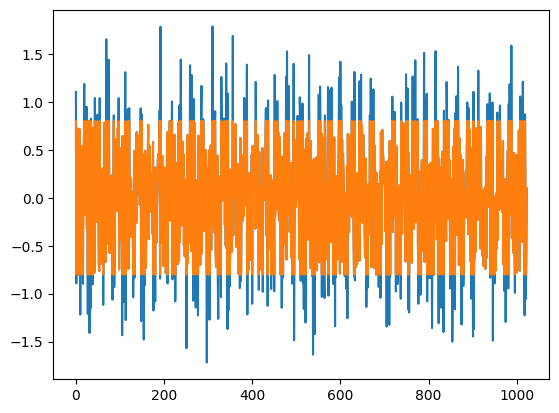

In [127]:
plt.plot(Y[0])
plt.plot(Y_clipped[0])

In [142]:
x_c, x_s, residual_norms = OMP(Y_clipped[0], get_M_r(Y_clipped[0]), 100, 1e-6)

100%|██████████| 100/100 [00:02<00:00, 39.77it/s]


In [143]:
y_reconstructed = gabor_cosine @ x_c + gabor_sine @ x_s

In [146]:
residual_norms

[11.776898306136477,
 11.184481129342464,
 10.505431542030442,
 9.673269330331907,
 8.669883172125264,
 7.321392955186249,
 6.308267093564592,
 5.43198481200208,
 4.44046181345222,
 3.3528661413913556,
 2.6882805430376577,
 2.67094621464166,
 2.651721257346229,
 2.635943185961245,
 2.6211280983010536,
 2.607242264499229,
 2.5933980766495672,
 2.57952878774279,
 2.5662291819457907,
 2.552863643840084,
 2.540100488882823,
 2.5273342489901687,
 2.513523303799354,
 2.5004110714274197,
 2.4875191613482794,
 2.4746207314022564,
 2.461194525461696,
 2.4487330794806152,
 2.4362777259816517,
 2.423817981244028,
 2.4116033533749874,
 2.399490176095934,
 2.387541147484003,
 2.375425232326909,
 2.363166925823308,
 2.3511930535024304,
 2.3397240208313628,
 2.328067348654546,
 2.3156423291841923,
 2.304125272519006,
 2.292878978065257,
 2.2817816161545785,
 2.2707046001778015,
 2.259569481235059,
 2.2488368896988162,
 2.2380114105027324,
 2.226683320684614,
 2.2155343021572502,
 2.204407374739074,
 

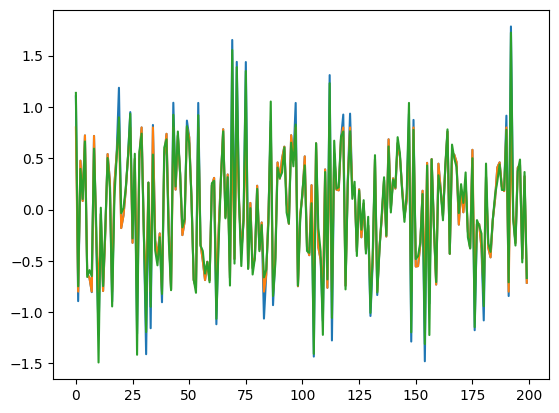

In [145]:
plt.plot(Y[0][:200])
plt.plot(Y_clipped[0][:200])
plt.plot(y_reconstructed[:200])
